Import necessary libraries

In [1]:
# Importing necessary libraries
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json

Defining Tan H activation functions

In [2]:
# Defining custom activation functions
def tanh_exp(x):
    # First Model (Exponential Form)
    x = tf.clip_by_value(x, -10, 10)
    exp_2x = tf.exp(2 * x)
    return (exp_2x - 1) / (exp_2x + 1 + 1e-7)

def tanh_lambert(x):
    # Second Model (Lambert's Continued Fraction)
    epsilon = 1e-7
    x = tf.clip_by_value(x, -10, 10)
    denom = 13.0
    denom = 11.0 + x / (denom + epsilon)
    denom = 9.0 + x / (denom + epsilon)
    denom = 7.0 + x / (denom + epsilon)
    denom = 5.0 + x / (denom + epsilon)
    denom = 3.0 + x / (denom + epsilon)
    return 1 / (1 + x / (denom + epsilon))

def tanh_modified_cf(x):
    # Third Model (Modified Continued Fraction)
    x = tf.clip_by_value(x, -10, 10)
    x2 = x * x
    epsilon = 1e-7
    denom = 13.0
    denom = 11.0 + x2 / (denom + epsilon)
    denom = 9.0 + x2 / (denom + epsilon)
    denom = 7.0 + x2 / (denom + epsilon)
    denom = 5.0 + x2 / (denom + epsilon)
    denom = 3.0 + x2 / (denom + epsilon)
    return x / (1 + x2 / (denom + epsilon))

def tanh_poly(x):
    # Fourth Model (Polynomial Approximation)
    x = tf.clip_by_value(x, -3, 3)
    x2 = x * x
    numerator = x * (x2 * (x2 * x2 + 378) + 17325 * x2 + 135135)
    denominator = x2 * (28 * x2 * x2 + 3150 * x2 + 62370) + 135135
    return numerator / (denominator + 1e-7)

def tanh_simplified_poly(x):
    # Fifth Model (Simplified Polynomial Approximation)
    x = tf.clip_by_value(x, -3, 3)
    x2 = x * x
    a = x * (((x2 + 378) * x2 + 17325) * x2 + 135135)
    b = ((28 * x2 + 3150) * x2 + 62370) * x2 + 135135
    return a / (b + 1e-7)


Corrected registration of activation functions

In [3]:
# Registering the custom activation functions
from tensorflow.keras.utils import get_custom_objects

get_custom_objects().update({
    'tanh_exp': tanh_exp,
    'tanh_lambert': tanh_lambert,
    'tanh_modified_cf': tanh_modified_cf,
    'tanh_poly': tanh_poly,
    'tanh_simplified_poly': tanh_simplified_poly,
})

Defining the CNN model

In [4]:
# Defining the model creation function
def create_model(activation_function):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation=activation_function, input_shape=(32, 32, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation=activation_function))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation=activation_function))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation=activation_function))
    model.add(layers.Dense(10))
    return model

Load and preprocess CIFAR-10 dataset

In [5]:
# Loading and preprocess CIFAR-10 data
from tensorflow.keras.datasets import cifar10

# Loading data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize pixel values to be between -1 and 1
x_train = x_train.astype('float32') / 127.5 - 1
x_test = x_test.astype('float32') / 127.5 - 1

# Ensuring labels are in the correct shape
y_train = y_train.squeeze()
y_test = y_test.squeeze()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


Defining function to compile and train the model

In [6]:
# Defining the compile and train function
def compile_and_train(model, x_train, y_train, x_test, y_test, epochs=10):
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    history = model.fit(x_train, y_train, epochs=epochs,
                        validation_data=(x_test, y_test), batch_size=64)
    return history

 Training models with different activation functions

In [7]:
# List of activation functions and their names
activation_functions = [
    ('tanh_exp', tanh_exp),
    ('tanh_lambert', tanh_lambert),
    ('tanh_modified_cf', tanh_modified_cf),
    ('tanh_poly', tanh_poly),
    ('tanh_simplified_poly', tanh_simplified_poly)
]

histories = []
models_list = []
final_accuracies = []  # Initializing the final accuracies list

# Training loop
for name, activation in activation_functions:
    print(f"Training model with activation function: {name}")
    model = create_model(activation)
    history = compile_and_train(model, x_train, y_train, x_test, y_test, epochs=10)
    histories.append(history)
    models_list.append(model)
    # Collectting final validation accuracy
    val_acc = history.history['val_accuracy'][-1]
    final_accuracies.append({'Activation Function': name, 'Validation Accuracy': val_acc})

Training model with activation function: tanh_exp


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.4370 - loss: 1.5726 - val_accuracy: 0.5891 - val_loss: 1.1753
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6165 - loss: 1.0947 - val_accuracy: 0.6419 - val_loss: 1.0310
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6645 - loss: 0.9688 - val_accuracy: 0.6539 - val_loss: 1.0072
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6958 - loss: 0.8797 - val_accuracy: 0.6785 - val_loss: 0.9442
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7151 - loss: 0.8260 - val_accuracy: 0.6730 - val_loss: 0.9467
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7319 - loss: 0.7725 - val_accuracy: 0.6815 - val_loss: 0.9324
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7507 - loss: 0.7224 - val_accuracy: 0.6778 - val_loss: 0.9409
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7686 - loss: 0.6770 - val_accuracy: 0

In [8]:
# Save final accuracies to a CSV file
df_accuracies = pd.DataFrame(final_accuracies)
df_accuracies.to_csv('final_accuracies.csv', index=False)

 Save the final accuracies to a CSV file

In [9]:
# Save histories data to a JSON file
# Prepare a list to store history data
histories_data = []

for history in histories:
    histories_data.append({
        'accuracy': history.history['accuracy'],
        'val_accuracy': history.history['val_accuracy']
    })

# Save histories data to a JSON file
with open('histories.json', 'w') as f:
    json.dump(histories_data, f)

print("Training complete. Histories and final accuracies saved.")

Training complete. Histories and final accuracies saved.


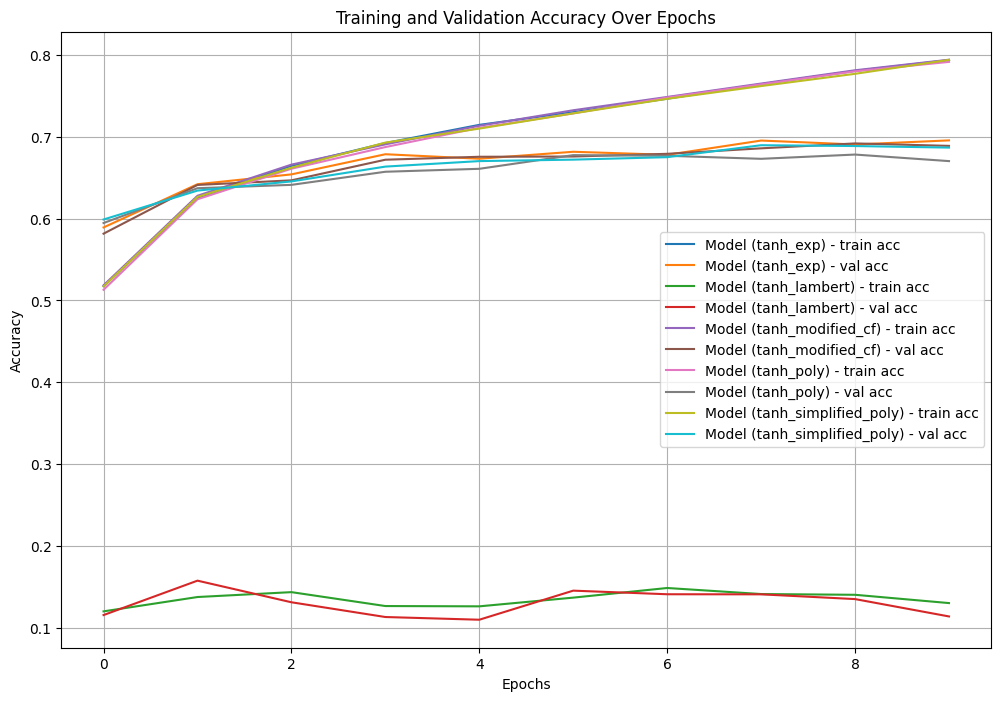

In [17]:
import matplotlib.pyplot as plt

def plot_accuracy_curves(histories, labels):
    plt.figure(figsize=(12, 8))
    for history, label in zip(histories, labels):
        plt.plot(history.history['accuracy'], label=f'{label} - train acc')
        plt.plot(history.history['val_accuracy'], label=f'{label} - val acc')
    plt.title('Training and Validation Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_loss_curves(histories, labels):
    plt.figure(figsize=(12, 8))
    for history, label in zip(histories, labels):
        plt.plot(history.history['loss'], label=f'{label} - train loss')
        plt.plot(history.history['val_loss'], label=f'{label} - val loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_accuracy_curves(histories, labels)


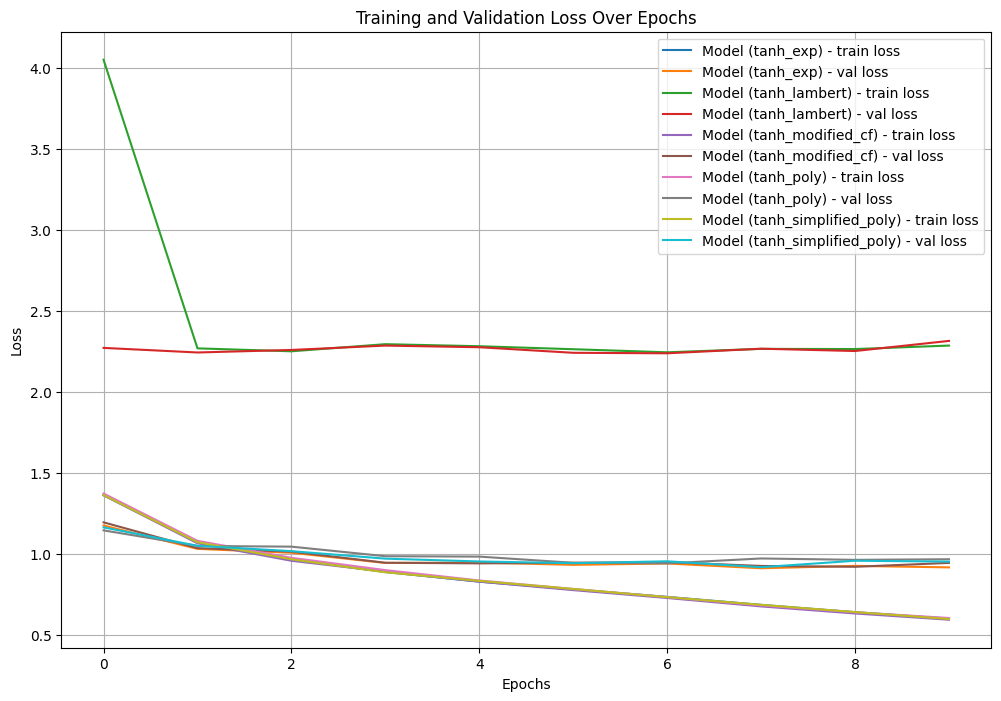

In [18]:
plot_loss_curves(histories, labels)

Printing final validation accuracies

In [19]:
def print_final_accuracy(history, model_name):
    val_acc = history.history['val_accuracy'][-1]
    print(f"{model_name} Validation Accuracy: {val_acc:.4f}")

for (name, _), history in zip(activation_functions, histories):
    print_final_accuracy(history, f"Model ({name})")

Model (tanh_exp) Validation Accuracy: 0.6954
Model (tanh_lambert) Validation Accuracy: 0.1141
Model (tanh_modified_cf) Validation Accuracy: 0.6887
Model (tanh_poly) Validation Accuracy: 0.6701
Model (tanh_simplified_poly) Validation Accuracy: 0.6866


Plotting validation accuracies over epochs

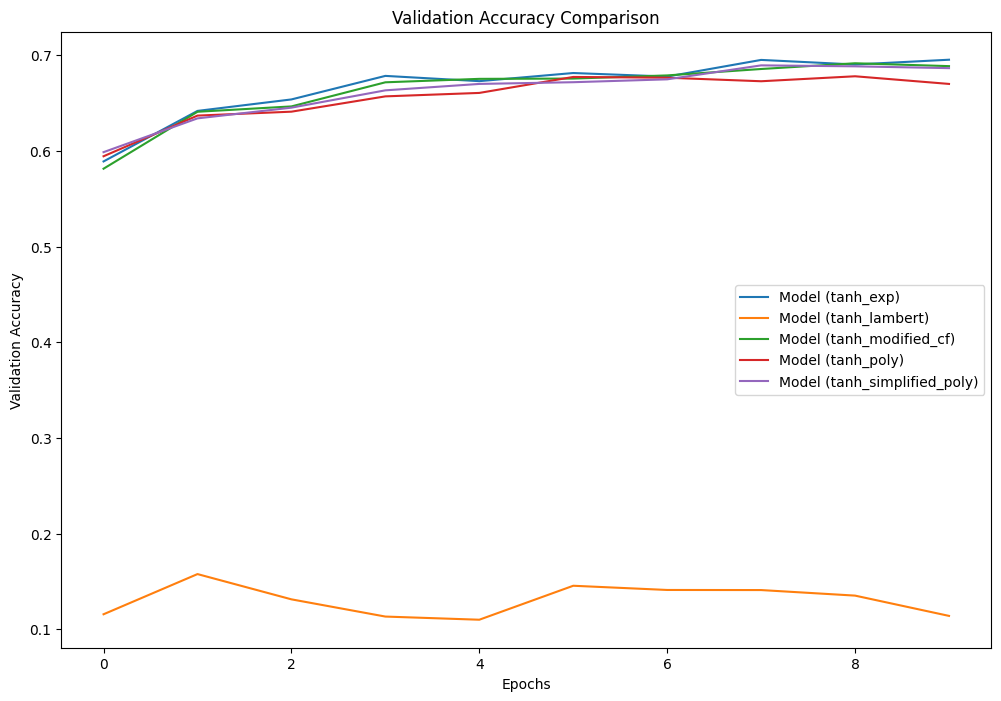

In [20]:
def plot_accuracy(histories, labels):
    plt.figure(figsize=(12, 8))
    for history, label in zip(histories, labels):
        plt.plot(history.history['val_accuracy'], label=label)
    plt.title('Validation Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Accuracy')
    plt.legend()
    plt.show()

labels = [f"Model ({name})" for name, _ in activation_functions]

plot_accuracy(histories, labels)


Plot validation accuracies over epochs with interactive plots

In [21]:
# Install and import Plotly libraries
#!pip install --upgrade plotly
import plotly.graph_objs as go
import plotly.io as pio

# Set the default renderer to 'colab' for Google Colab
pio.renderers.default = 'colab'

def plot_separate_interactive_accuracy(histories, labels):
    for history, label in zip(histories, labels):
        val_acc = history.history['val_accuracy']
        epochs = list(range(1, len(val_acc) + 1))

        # Create a trace for the plot
        trace = go.Scatter(
            x=epochs,
            y=val_acc,
            mode='lines+markers',
            name=label,
            hoverinfo='text',
            text=[f'Epoch {epoch}: {acc:.4f}' for epoch, acc in zip(epochs, val_acc)]
        )

        # Define the layout of the plot
        layout = go.Layout(
            title=f'Validation Accuracy for {label}',
            xaxis=dict(title='Epochs'),
            yaxis=dict(title='Validation Accuracy'),
            hovermode='closest'
        )

        # Create a figure with the trace and layout
        fig = go.Figure(data=[trace], layout=layout)

        # Display the interactive plot
        fig.show()

labels = [f"Model ({name})" for name, _ in activation_functions]

# Call the function to plot interactive validation accuracies
plot_separate_interactive_accuracy(histories, labels)